In [1]:
using Plots
include("polyfit_function.jl")
include("Lagrange_interpolation.jl")

Lagrange (generic function with 1 method)

In [2]:
function bdf2(f, tspan, y0, N)
    h = (tspan[2] - tspan[1]) / N
    t = Vector(range(tspan[1], tspan[2], length=N+1))
    y = zeros(N + 1, 1)
    y[1] = y0
    y[2]=(y[1]+0.5*h*lambda*y[1])/(1-0.5*h*lambda)
    # Two-step BDF for Dalquist test equation y'=lambda * y
    for i in 1:(N-1)
        y[i+2]= ((4/3)*y[i+1]-(1/3)*y[i])/((1-(2/3)*h*lambda))
    end
    return t, y
end

bdf2 (generic function with 1 method)

convergence order = 1.9987384308498226


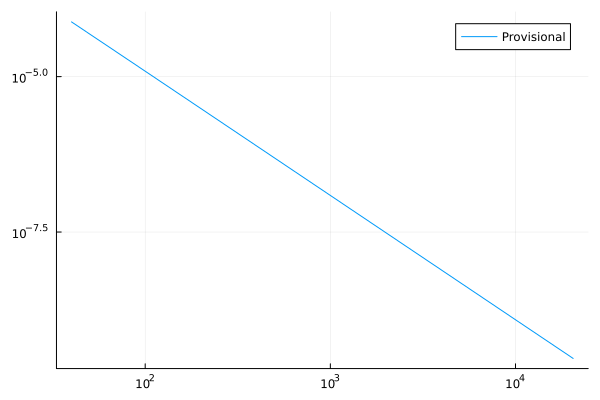

In [26]:
# Convergence Analysis of BDF2 method
y0 = 1.0
lambda=-1
tspan=[0 1.0]
K = 10
err2 = zeros(K, 1)
ns=zeros(K, 1)
for k in 1:K
    N = 20* 2^k
    ns[k]=N
    h = (tspan[2] - tspan[1]) / N
    f(t, y) = lambda * y
    (t, y) = bdf2(f, tspan, y0, N)
    exact2 = y0 * exp.(lambda * t)
    
    # Storing errors
    for i in 1:K+1
        err2[k] = norm(exact2[N+1] .- y[N+1])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err2[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err2[:, 1],xaxis=:log, yaxis=:log, label="Provisional")
display(plot!(legend=:topright))

In [3]:
# Creating RIDC step function
function ridc_bdf2(f, tspan, lambda, h, y0, N, K)
    y=zeros(1, N+1, K+1)
    t, y[1, :, 1]=bdf2(f, tspan, y0, N) # storing the provisional solution
   
   for k in 1:K
        y[1, 1, k+1]=y0 # initial condition
        nfval=f(t, y[1, :, k]) # New function value
        
        # (2k+2) equi-spaced nodes are used where k is the iteration number. 
        
        # First step computed by Trapezoidal(implicit) method
        Qdr1=Lagrange(t[1:2*k+2], nfval[1:2*k+2], t[1], t[2])
        
        c1=(y[1, 1, k+1]-0.5*h*lambda*y[1, 2, k]+0.5*h*lambda*y[1,1,k+1]- 0.5*h*lambda*y[1, 1, k])
       
        
        y[1, 2, k+1]= (c1 + Qdr1)/(1-0.5*h*lambda)
        
        
        
        # First nth steps
        for n in 3:(2*k+1)
            Q1= (1/3)*Lagrange(t[1:(2*k+2)], nfval[1:(2*k+2)], t[n-2], t[n-1])
            Q2=Lagrange(t[1:(2*k+2)], nfval[1:(2*k+2)], t[n-1], t[n])
            c2=(4/3)*y[1, n-1, k+1]-(1/3)*y[1, n-2, k+1]-(2/3)*h*lambda*y[1, n, k]
            y[1, n, k+1]= (c2 -Q1+Q2)/(1-(2/3)*h*lambda)
        end
        
        for j in (2*k+2):(N+1)
            Q1= (1/3)*Lagrange(t[j-(2*k+1):j], nfval[j-(2*k+1):j], t[j-2], t[j-1])
            Q2=Lagrange(t[j-(2*k+1):j], nfval[j-(2*k+1):j], t[j-1], t[j])
            c2=(4/3)*y[1, j-1, k+1]-(1/3)*y[1, j-2, k+1]-(2/3)*h*lambda*y[1, j, k]
            y[1, j, k+1]= (c2 -Q1+Q2)/(1-(2/3)*h*lambda)
        end
            
    end
    return t,  y
end

ridc_bdf2 (generic function with 1 method)

convergence order = 2.0254244162028328
convergence order = 4.045871505713881
convergence order = 6.1201021883564675


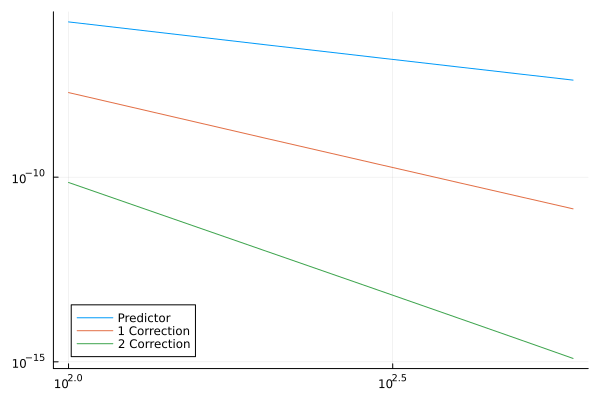

In [4]:
# Example 1: y'=lambda* y, y(0)=1; T in [0, 10]

using Plots
P = 6
y0 = 1.0
lambda=-1
tspan=[0 10]
K = 2
err = zeros(P, K + 1)
ns=zeros(P, 1)
for p in 1:P
    N = 100*p
    ns[p]=N
    h = (tspan[2] - tspan[1]) / N
    f(t, y) = lambda * y
    
    (t, y) = ridc_bdf2(f, tspan, lambda, h, y0, N, K)
    
    exact = y0 * exp.(lambda * t)
   
    # Storing errors
    
    # Storing errors
    for i in 1:K+1
        err[p, i] = norm(exact[N+1] .- y[1, N+1, i])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:, 1],xaxis=:log, yaxis=:log, label="Predictor")

for j in 2:K+1
    plot!(ns, err[:,j],xaxis=:log, yaxis=:log, label="$(j-1) Correction")
    pdeg = polyfit(log10.(ns[:]), log10.(err[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:bottomleft))

# Test problem from the paper

$$y'=-2\pi \, sin(2\pi t)- 2y+ 2cos(2\pi t); \quad y(0)=1$$

In [5]:
# Hard coded function

function bdf2p2(tspan, y0, N)
    h = (tspan[2] - tspan[1]) / N
    t = Vector(range(tspan[1], tspan[2], length=N+1))
    y = zeros(N + 1, 1)
    y[1] = y0
    y[2]= (y[1]-h*(y[1]+pi* sin.(2*pi*t[2])+ pi*sin.(2*pi*t[1])-cos.(2*pi*t[2])-cos.(2*pi*t[1])))/(1+h)
    # Two-step BDF 
    for i in 1:(N-1)
        y[i+2]= ((4/3)*y[i+1]-(1/3)*y[i]+(2/3)*h*(-2*pi*sin.(2*pi*t[i+2])+2*cos.(2*pi*t[i+2])))/((1+(4/3)*h))
    end
    return t, y
end

bdf2p2 (generic function with 1 method)

convergence order = 2.0027788095891506


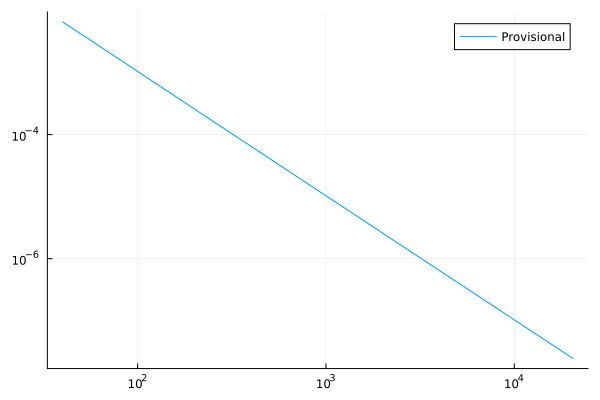

In [30]:
# Convergence Analysis for Test Problem y'=-2*pi*sin(2*pi*t)-2y+2cos(2*pi*t)
y0 = 1.0
tspan=[0 1.0]
K = 10
err2 = zeros(K, 1)
ns=zeros(K, 1)
for k in 1:K
    N = 20* 2^k
    ns[k]=N
    h = (tspan[2] - tspan[1]) / N
    
    (t, y) = bdf2p2(tspan, y0, N)
    exact2 = cos.(2*pi*t)
    
    # Storing errors
    for i in 1:K+1
        err2[k] = norm(exact2[N+1] .- y[N+1])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err2[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err2[:, 1],xaxis=:log, yaxis=:log, label="Provisional")
display(plot!(legend=:topright))

In [6]:
# Creating RIDC step function
function ridc_bdf2p2(f, tspan, h, y0, N, K)
    y=zeros(1, N+1, K+1)
    t, y[1, :, 1]=bdf2p2(tspan, y0, N) # storing the provisional solution
   
   for k in 1:K
        y[1, 1, k+1]=y0 # initial condition
        nfval=f(t, y[1, :, k]) # New function value
        
        # (2k+2) equi-spaced nodes are used where k is the iteration number. 
        
        # First step computed by Trapezoidal method (Hard coded)
        Qdr1=Lagrange(t[1:2*k+2], nfval[1:2*k+2], t[1], t[2])
        
        c1=(y[1, 1, k+1]+h*(y[1, 2, k]-y[1, 1, k+1]+ y[1, 1, k]))
       
        
        y[1, 2, k+1]= (c1 + Qdr1)/(1+h)
        
        
        
        # First nth steps
        for n in 3:(2*k+1)
            Q1= (1/3)*Lagrange(t[1:(2*k+2)], nfval[1:(2*k+2)], t[n-2], t[n-1])
            Q2=Lagrange(t[1:(2*k+2)], nfval[1:(2*k+2)], t[n-1], t[n])
            c2=(4/3)*y[1, n-1, k+1]-(1/3)*y[1, n-2, k+1]+(4/3)*h*y[1, n, k]
            y[1, n, k+1]= (c2 -Q1+Q2)/(1+(4/3)*h)
        end
        
        for j in (2*k+2):(N+1)
            Q1= (1/3)*Lagrange(t[j-(2*k+1):j], nfval[j-(2*k+1):j], t[j-2], t[j-1])
            Q2=Lagrange(t[j-(2*k+1):j], nfval[j-(2*k+1):j], t[j-1], t[j])
            c2=(4/3)*y[1, j-1, k+1]-(1/3)*y[1, j-2, k+1]+(4/3)*h*y[1, j, k]
            y[1, j, k+1]= (c2 -Q1+Q2)/(1+(4/3)*h)
        end
            
    end
    return t,  y
end

ridc_bdf2p2 (generic function with 1 method)

convergence order = 2.0053442157881722
convergence order = 3.9840280646799124
convergence order = 6.0167844922743825


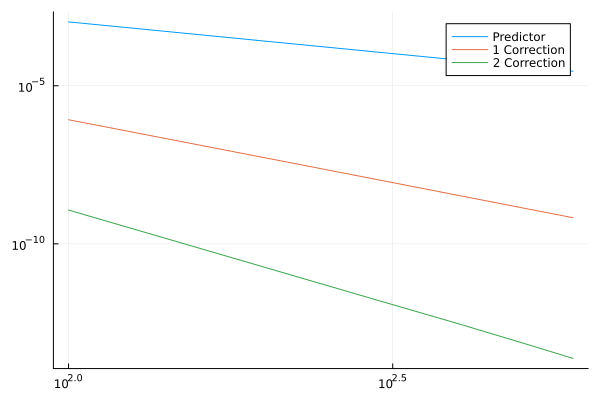

In [8]:
#Example 

using Plots
P = 6
y0 = 1.0
tspan=[0 1]
K = 2
err = zeros(P, K + 1)
ns=zeros(P, 1)
for p in 1:P
    N = 100*p
    ns[p]=N
    h = (tspan[2] - tspan[1]) / N
    f(t, y) = -2*pi*sin.(2*pi*t)-2*y + 2*cos.(2*pi*t)
    
    (t, y) = ridc_bdf2p2(f, tspan, h, y0, N, K)
    
    exact = cos.(2*pi*t)
   
    # Storing errors
    
    # Storing errors
    for i in 1:K+1
        err[p, i] = norm(exact[N+1] .- y[1, N+1, i])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:, 1],xaxis=:log, yaxis=:log, label="Predictor")

for j in 2:K+1
    plot!(ns, err[:,j],xaxis=:log, yaxis=:log, label="$(j-1) Correction")
    pdeg = polyfit(log10.(ns[:]), log10.(err[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))